## Plot validation of meridional transports of heat, freshwater and carbon from OTM solution

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

### Get transports for run with prior with true fluxes (case 2)

In [2]:
# Load MTM result

OTMrun='true'

carbon_preflux = True

yr_init=1992

Opt_result = xr.open_mfdataset(OTMrun+'_transports.nc')

Basins = Opt_result.Basins
tree_depth=int(math.log2(Opt_result.tree_depth))

month_init_early=(Opt_result.init_early-yr_init)*12
month_init_late=(Opt_result.init_late-yr_init)*12
Early_period = (np.array([month_init_early,month_init_early+Opt_result.dyrs*12]))
Late_period = (np.array([month_init_late,month_init_late+Opt_result.dyrs*12]))

dt = Opt_result.dt.values
dyrs = Opt_result.dyrs.astype('float64')

In [3]:
# Establish basic constants 

Cp=4000
rho=1029
S0=35

yr2sec = 3600 * 24 * 365.25

In [4]:
## Load BSP data

ECCO_BSP_data = xr.open_mfdataset(('C:/Users/nm455/OneDrive - University of Exeter/UNICORNS/MTM/tree_depth_6_BSP_ECCO/9_Basins_fluxerr_6/BSP_ECCO_monthly_*'))
    
## Early Period
Part_early = ECCO_BSP_data.Partitions_hist.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
SA_early =  ECCO_BSP_data.S_mean_hist.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
CT_early = ECCO_BSP_data.T_mean_hist.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
C_early = ECCO_BSP_data.C_mean_hist.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')                                 
V_early = ECCO_BSP_data.V_sum_hist.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
A_early = ECCO_BSP_data.A_sum_hist.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
# Asection_early = ACCESS_BSP_data.Asection_sum.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')

## Late Period
Part_late = ECCO_BSP_data.Partitions_hist.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
SA_late =  ECCO_BSP_data.S_mean_hist.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
CT_late = ECCO_BSP_data.T_mean_hist.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
C_late = ECCO_BSP_data.C_mean_hist.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
V_late = ECCO_BSP_data.V_sum_hist.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
A_late = ECCO_BSP_data.A_sum_hist.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
# Asection_late = ACCESS_BSP_data.Asection_sum.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')

Basins = ECCO_BSP_data.Basin.values
# Sections = ACCESS_BSP_data.Section.values

ECCO_time = xr.open_mfdataset('C:/Users/nm455/OneDrive - University of Exeter/UNICORNS/ECCO-Darwin/ECCO_time.nc')
ECCO_dt=(np.hstack([ECCO_time.ECCO_time[0].values,np.diff(ECCO_time.ECCO_time)])).reshape(1,323,1)
ECCO_dt=ECCO_dt[:,0:ECCO_BSP_data.Time.size,:]


In [5]:
# Flatten the early and late variables to a 1D array
Vol_1 = V_early.values.flatten()
Vol_2 = V_late.values.flatten()
S_1 = SA_early.values.flatten()-S0 # Remove reference salinity S0
S_2 = SA_late.values.flatten()-S0 # Remove reference salinity S0
T_1 = CT_early.values.flatten()
T_2 = CT_late.values.flatten()
C_1 = C_early.values.flatten()
C_2 = C_late.values.flatten()
A_1 = A_early.values.flatten()
A_2 = A_late.values.flatten()

# Do the same for basin index
Basin_1 = np.zeros_like(V_early)
Basin_2 = np.zeros_like(V_early)
Basin_names = []
for i in range(np.array(Basins).size):
    Basin_1[i,:] = i
    Basin_2[i,:] = i
    for j in range(V_early.shape[-1]):
        #... and for basin name
        Basin_names.append(Basins[i])

Basin_1_inds = Basin_1.flatten()
Basin_2_inds = Basin_2.flatten()

#... and for the edges of the BSP bins
## Here we calculate the mean TS edges averaged over both early and late times
S_start = (0.5*(Part_early.values[:,:,0]+Part_late.values[:,:,0])).flatten()-S0 # Remove reference salinity S0
S_end = (0.5*(Part_early.values[:,:,1]+Part_late.values[:,:,1])).flatten()-S0 # Remove reference salinity S0
T_start = (0.5*(Part_early.values[:,:,2]+Part_late.values[:,:,2])).flatten()
T_end = (0.5*(Part_early.values[:,:,3]+Part_late.values[:,:,3])).flatten()

In [6]:
## Load surface flux data here, if provided

## Calculate the cumulative time integrated surface fluxes 
HFDS_cumsum = ((ECCO_BSP_data.hfds_sum_hist*ECCO_dt).cumsum('Time').isel(Time=Late_period[-1]))\
    -((ECCO_BSP_data.hfds_sum_hist*ECCO_dt).cumsum('Time').isel(Time=Early_period[0])) # units: J
SFI_cumsum = ((ECCO_BSP_data.sfi_sum_hist*ECCO_dt).cumsum('Time').isel(Time=Late_period[-1]))\
    -((ECCO_BSP_data.sfi_sum_hist*ECCO_dt).cumsum('Time').isel(Time=Early_period[0]))# units: g
WFO_cumsum = ((ECCO_BSP_data.wfo_sum_hist*ECCO_dt).cumsum('Time').isel(Time=Late_period[-1]))\
    -((ECCO_BSP_data.wfo_sum_hist*ECCO_dt).cumsum('Time').isel(Time=Early_period[0]))# units: kg
Cflux_cumsum = ((ECCO_BSP_data.Cflux_sum_hist*ECCO_dt).cumsum('Time').isel(Time=Late_period[-1]))\
    -((ECCO_BSP_data.Cflux_sum_hist*ECCO_dt).cumsum('Time').isel(Time=Early_period[0])) # units: mmol-C
    
dt_cumsum = ECCO_dt[0,Early_period[0]:Late_period[-1],0].sum() # units: seconds
    
    
## The final dflux value is then scaled by the time between the middle of t1 and the middle of t2
dhfds = HFDS_cumsum*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-Early_period[0]))
dsfi = SFI_cumsum*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-Early_period[0]))
dwfo = WFO_cumsum*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-Early_period[0]))
dCflux = Cflux_cumsum*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-Early_period[0]))
dt = dt_cumsum*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-Early_period[0]))

## Convert dflux to equivalent T or S change

dT_hfds = dhfds/(Cp*rho*V_early) # units: C
dS_sfi = dsfi/(rho*V_early) # units: g/kg
dS_wfo = -dwfo*S0/(rho*V_early) # units: g/kg
dC_Cflux = dCflux/V_early # units: mmol-C/m^3

time = ECCO_BSP_data.Time.values

S_pre = SA_early.values.flatten()-S0
S_1 = SA_early.values.flatten()-S0+dS_wfo.values.flatten()
T_pre = CT_early.values.flatten()
T_1 = CT_early.values.flatten()+dT_hfds.values.flatten()

if carbon_preflux:
    
    dC_Cflux = Opt_result.dC_Cflux
    dC_Cflux[np.isnan(dC_Cflux)] = 0
    dC_Cflux[~np.isfinite(dC_Cflux)] = 0
    
    C_1 = C_early.values.flatten() + dC_Cflux

S_1[np.isnan(S_1)] = 0
T_1[np.isnan(T_1)] = 0
C_1[np.isnan(C_1)] = 0
S_1[~np.isfinite(S_1)] = 0
T_1[~np.isfinite(T_1)] = 0
C_1[~np.isfinite(C_1)] = 0


C:\Users\nm455\Anaconda3\envs\MTM\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\nm455\Anaconda3\envs\MTM\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [7]:
# Array defining the connection between the 9 basins;
# 1 = connected (sign convention: North = +, East = +), 0 = disconnected
d_ij = np.zeros((Basins.size,Basins.size))

d_ij[0,:] = [1, -1, 0, 0, 0, 0, 0, -1, 0]
d_ij[1,:] = [1, 1, -1, 0, 0, 0, 0, 0, 0]
d_ij[2,:] = [0, 1, 1, -1, 0, 0, 0, 0, 0]
d_ij[3,:] = [0, 0, 1, 1, 0, 0, 0, 0, -1]
d_ij[4,:] = [0, 0, 0, 0, 1, 0, 1, 0, -1]
d_ij[5,:] = [0, 0, 0, 0, 0, 1, 1, 0, -1]
d_ij[6,:] = [0, 0, 0, 0, -1, -1, 1, 1, 0]
d_ij[7,:] = [1, 0, 0, 0, 0, 0, -1, 1, 0]
d_ij[8,:] = [0, 0, 0, 1, 1, 1, 0, 0, 1]

d = {Basins[0]: d_ij.T[0,:],\
    Basins[1]: d_ij.T[1,:],\
    Basins[2]: d_ij.T[2,:],\
    Basins[3]: d_ij.T[3,:],\
    Basins[4]: d_ij.T[4,:],\
    Basins[5]: d_ij.T[5,:],\
    Basins[6]: d_ij.T[6,:],\
    Basins[7]: d_ij.T[7,:],\
    Basins[8]: d_ij.T[8,:]}
    
table = pd.DataFrame(data=d, index=Basins)
table

,Polar N. Atlantic,Subtropical N. Atlantic,Eq. Atlantic,S. Atlantic,Indian,S. Pacific,Eq. Pacific,N. Pacific,Southern Ocean
Polar N. Atlantic,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0
Subtropical N. Atlantic,1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
Eq. Atlantic,0.0,1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0
S. Atlantic,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,-1.0
Indian,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-1.0
S. Pacific,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-1.0
Eq. Pacific,0.0,0.0,0.0,0.0,-1.0,-1.0,1.0,1.0,0.0
N. Pacific,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0
Southern Ocean,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0


In [8]:
g_ij = Opt_result.gij.values

section_trans = np.zeros((Vol_1.size,Vol_1.size))

for i in (range(Vol_1.size)):
    for j in range(Vol_2.size):
        if d_ij[int(Basin_1_inds[i]), int(Basin_2_inds[j])]!=0:
            if Basin_names[i] != Basin_names[j]:
                section_trans[i,j] = g_ij[i,j]/(dt*10**6)*d_ij[int(Basin_1_inds[i]), int(Basin_2_inds[j])] # Sv

int_section_trans = np.zeros((Basins.size, Basins.size))
int_section_trans_C = np.zeros((Basins.size, Basins.size))
for i in (range(Basins.size)):
    for j in range(Basins.size):
        int_section_trans[i,j] = np.nansum(section_trans[V_early.shape[1]*i:(V_early.shape[1]*(i+1)),V_early.shape[1]*j:(V_early.shape[1]*(j+1))])

section_trans_temp = np.zeros((Vol_1.size, Basins.size))

for j in range(Basins.size):
    section_trans_temp[:,j] = np.nansum(section_trans[:,V_early.shape[1]*j:(V_early.shape[1]*(j+1))],axis=-1)

In [9]:
basin_connex = np.array([[0,1],
                [1,2],
                [2,3],
                [3,8],
                [4,8],
                [4,6],
                [5,8],
                [6,5],
                [7,6],
                [7,0]]).astype(int)

T_joined = np.zeros((int(np.size(basin_connex)/2), int(V_early.shape[1]*2)))
S_joined = np.zeros((int(np.size(basin_connex)/2), int(V_early.shape[1]*2)))
C_joined = np.zeros((int(np.size(basin_connex)/2), int(V_early.shape[1]*2)))
section_joined = np.zeros((int(np.size(basin_connex)/2), int(V_early.shape[1]*2)))

for i in range(int(np.size(basin_connex)/2)):
    T_joined[i,:] = np.concatenate([T_1[V_early.shape[1]*basin_connex[i][0]:(V_early.shape[1]*(basin_connex[i][0]+1))],T_1[V_early.shape[1]*basin_connex[i][1]:(V_early.shape[1]*(basin_connex[i][1]+1))]])
    S_joined[i,:] = np.concatenate([S_1[V_early.shape[1]*basin_connex[i][0]:(V_early.shape[1]*(basin_connex[i][0]+1))],S_1[V_early.shape[1]*basin_connex[i][1]:(V_early.shape[1]*(basin_connex[i][1]+1))]])
    C_joined[i,:] = np.concatenate([C_1[V_early.shape[1]*basin_connex[i][0]:(V_early.shape[1]*(basin_connex[i][0]+1))],C_1[V_early.shape[1]*basin_connex[i][1]:(V_early.shape[1]*(basin_connex[i][1]+1))]])
    section_joined[i,:] = np.concatenate([section_trans_temp[V_early.shape[1]*basin_connex[i][0]:(V_early.shape[1]*(basin_connex[i][0]+1)),basin_connex[i][1]],\
        section_trans_temp[V_early.shape[1]*basin_connex[i][1]:(V_early.shape[1]*(basin_connex[i][1]+1)),basin_connex[i][0]]])


In [10]:
# Calculate meridional transports from OTM

heat_trans = T_joined*section_joined*rho*Cp*10**6
HF_section_tot = np.nansum(heat_trans, axis=-1)/10**12

fw_trans = -1/(S0*rho)*S_joined*section_joined*10**3
FW_section_tot = np.nansum(fw_trans, axis=-1) # Sv

C_trans = C_joined*section_joined*10**6*yr2sec/(10**18/12) # PgC/yr
CF_section_tot = np.nansum(C_trans, axis=-1)


In [11]:
## Extract OTM solution section totals

lats_global=[10,-35]
lats_ATL=[40,10,-10,-35]
lats_INDPAC=[10,-35]

# Heat

heattransp_global_MTM=np.zeros((2,1))
heattransp_global_MTM[0]=(HF_section_tot[1]+HF_section_tot[8])
heattransp_global_MTM[1]=(HF_section_tot[4]+HF_section_tot[6]+HF_section_tot[3])

heattransp_ATL_MTM=np.zeros((4,1))
heattransp_ATL_MTM[0]=(HF_section_tot[0]+HF_section_tot[9])
heattransp_ATL_MTM[1]=(HF_section_tot[1]+HF_section_tot[9])
heattransp_ATL_MTM[2]=(HF_section_tot[2]+HF_section_tot[9])
heattransp_ATL_MTM[3]=(HF_section_tot[3]+HF_section_tot[9])

heattransp_INDPAC_MTM=np.zeros((2,1))
heattransp_INDPAC_MTM[1]=(HF_section_tot[6]+HF_section_tot[4]-HF_section_tot[9])
heattransp_INDPAC_MTM[0]=(HF_section_tot[8]-HF_section_tot[9])

# Freshwater

fwtransp_global_MTM=np.zeros((2,1))
fwtransp_global_MTM[0]=(FW_section_tot[1]+FW_section_tot[8])
fwtransp_global_MTM[1]=(FW_section_tot[4]+FW_section_tot[6]+FW_section_tot[3])

fwtransp_ATL_MTM=np.zeros((4,1))
fwtransp_ATL_MTM[0]=(FW_section_tot[0]+FW_section_tot[9])
fwtransp_ATL_MTM[1]=(FW_section_tot[1]+FW_section_tot[9])
fwtransp_ATL_MTM[2]=(FW_section_tot[2]+FW_section_tot[9])
fwtransp_ATL_MTM[3]=(FW_section_tot[3]+FW_section_tot[9])

fwtransp_INDPAC_MTM=np.zeros((2,1))
fwtransp_INDPAC_MTM[1]=(FW_section_tot[6]+FW_section_tot[4]-FW_section_tot[9])
fwtransp_INDPAC_MTM[0]=(FW_section_tot[8]-FW_section_tot[9])

# Carbon

Ctransp_global_MTM=np.zeros((2,1))
Ctransp_global_MTM[0]=(CF_section_tot[1]+CF_section_tot[8])
Ctransp_global_MTM[1]=(CF_section_tot[4]+CF_section_tot[6]+CF_section_tot[3])

Ctransp_ATL_MTM=np.zeros((4,1))
Ctransp_ATL_MTM[0]=(CF_section_tot[0]+CF_section_tot[9])
Ctransp_ATL_MTM[1]=(CF_section_tot[1]+CF_section_tot[9])
Ctransp_ATL_MTM[2]=(CF_section_tot[2]+CF_section_tot[9])
Ctransp_ATL_MTM[3]=(CF_section_tot[3]+CF_section_tot[9])

Ctransp_INDPAC_MTM=np.zeros((2,1))
Ctransp_INDPAC_MTM[1]=(CF_section_tot[6]+CF_section_tot[4]-CF_section_tot[9])
Ctransp_INDPAC_MTM[0]=(CF_section_tot[8]-CF_section_tot[9])


### Get transports for run with no prior (case 1)

In [12]:
# Load MTM result

OTMrun='noprior'
carbon_preflux = False

yr_init=1992

Opt_result = xr.open_mfdataset(OTMrun+'_transports.nc')

C_1 = C_early.values.flatten()
C_2 = C_late.values.flatten()

dC_Cflux = dCflux/V_early # units: mmol-C/m^3

C_1[np.isnan(C_1)] = 0
C_1[~np.isfinite(C_1)] = 0


In [13]:
g_ij = Opt_result.gij.values

section_trans = np.zeros((Vol_1.size,Vol_1.size))

for i in (range(Vol_1.size)):
    for j in range(Vol_2.size):
        if d_ij[int(Basin_1_inds[i]), int(Basin_2_inds[j])]!=0:
            if Basin_names[i] != Basin_names[j]:
                section_trans[i,j] = g_ij[i,j]/(dt*10**6)*d_ij[int(Basin_1_inds[i]), int(Basin_2_inds[j])] # Sv

int_section_trans = np.zeros((Basins.size, Basins.size))
int_section_trans_C = np.zeros((Basins.size, Basins.size))
for i in (range(Basins.size)):
    for j in range(Basins.size):
        int_section_trans[i,j] = np.nansum(section_trans[V_early.shape[1]*i:(V_early.shape[1]*(i+1)),V_early.shape[1]*j:(V_early.shape[1]*(j+1))])

section_trans_temp = np.zeros((Vol_1.size, Basins.size))

for j in range(Basins.size):
    section_trans_temp[:,j] = np.nansum(section_trans[:,V_early.shape[1]*j:(V_early.shape[1]*(j+1))],axis=-1)

In [14]:
T_joined = np.zeros((int(np.size(basin_connex)/2), int(V_early.shape[1]*2)))
S_joined = np.zeros((int(np.size(basin_connex)/2), int(V_early.shape[1]*2)))
C_joined = np.zeros((int(np.size(basin_connex)/2), int(V_early.shape[1]*2)))
section_joined = np.zeros((int(np.size(basin_connex)/2), int(V_early.shape[1]*2)))

for i in range(int(np.size(basin_connex)/2)):
    T_joined[i,:] = np.concatenate([T_1[V_early.shape[1]*basin_connex[i][0]:(V_early.shape[1]*(basin_connex[i][0]+1))],T_1[V_early.shape[1]*basin_connex[i][1]:(V_early.shape[1]*(basin_connex[i][1]+1))]])
    S_joined[i,:] = np.concatenate([S_1[V_early.shape[1]*basin_connex[i][0]:(V_early.shape[1]*(basin_connex[i][0]+1))],S_1[V_early.shape[1]*basin_connex[i][1]:(V_early.shape[1]*(basin_connex[i][1]+1))]])
    C_joined[i,:] = np.concatenate([C_1[V_early.shape[1]*basin_connex[i][0]:(V_early.shape[1]*(basin_connex[i][0]+1))],C_1[V_early.shape[1]*basin_connex[i][1]:(V_early.shape[1]*(basin_connex[i][1]+1))]])
    section_joined[i,:] = np.concatenate([section_trans_temp[V_early.shape[1]*basin_connex[i][0]:(V_early.shape[1]*(basin_connex[i][0]+1)),basin_connex[i][1]],\
        section_trans_temp[V_early.shape[1]*basin_connex[i][1]:(V_early.shape[1]*(basin_connex[i][1]+1)),basin_connex[i][0]]])


In [15]:
# Calculate meridional transports from OTM

heat_trans = T_joined*section_joined*rho*Cp*10**6
HF_section_tot = np.nansum(heat_trans, axis=-1)/10**12

fw_trans = -1/(S0*rho)*S_joined*section_joined*10**3
FW_section_tot = np.nansum(fw_trans, axis=-1) # Sv

C_trans = C_joined*section_joined*10**6*yr2sec/(10**18/12) # PgC/yr
CF_section_tot = np.nansum(C_trans, axis=-1)


In [16]:
## Extract OTM solution section totals

# Heat

heattransp_global_MTM_noprior=np.zeros((2,1))
heattransp_global_MTM_noprior[0]=(HF_section_tot[1]+HF_section_tot[8])
heattransp_global_MTM_noprior[1]=(HF_section_tot[4]+HF_section_tot[6]+HF_section_tot[3])

heattransp_ATL_MTM_noprior=np.zeros((4,1))
heattransp_ATL_MTM_noprior[0]=(HF_section_tot[0]+HF_section_tot[9])
heattransp_ATL_MTM_noprior[1]=(HF_section_tot[1]+HF_section_tot[9])
heattransp_ATL_MTM_noprior[2]=(HF_section_tot[2]+HF_section_tot[9])
heattransp_ATL_MTM_noprior[3]=(HF_section_tot[3]+HF_section_tot[9])

heattransp_INDPAC_MTM_noprior=np.zeros((2,1))
heattransp_INDPAC_MTM_noprior[1]=(HF_section_tot[6]+HF_section_tot[4]-HF_section_tot[9])
heattransp_INDPAC_MTM_noprior[0]=(HF_section_tot[8]-HF_section_tot[9])

# Freshwater

fwtransp_global_MTM_noprior=np.zeros((2,1))
fwtransp_global_MTM_noprior[0]=(FW_section_tot[1]+FW_section_tot[8])
fwtransp_global_MTM_noprior[1]=(FW_section_tot[4]+FW_section_tot[6]+FW_section_tot[3])

fwtransp_ATL_MTM_noprior=np.zeros((4,1))
fwtransp_ATL_MTM_noprior[0]=(FW_section_tot[0]+FW_section_tot[9])
fwtransp_ATL_MTM_noprior[1]=(FW_section_tot[1]+FW_section_tot[9])
fwtransp_ATL_MTM_noprior[2]=(FW_section_tot[2]+FW_section_tot[9])
fwtransp_ATL_MTM_noprior[3]=(FW_section_tot[3]+FW_section_tot[9])

fwtransp_INDPAC_MTM_noprior=np.zeros((2,1))
fwtransp_INDPAC_MTM_noprior[1]=(FW_section_tot[6]+FW_section_tot[4]-FW_section_tot[9])
fwtransp_INDPAC_MTM_noprior[0]=(FW_section_tot[8]-FW_section_tot[9])

# Carbon

Ctransp_global_MTM_noprior=np.zeros((2,1))
Ctransp_global_MTM_noprior[0]=(CF_section_tot[1]+CF_section_tot[8])
Ctransp_global_MTM_noprior[1]=(CF_section_tot[4]+CF_section_tot[6]+CF_section_tot[3])

Ctransp_ATL_MTM_noprior=np.zeros((4,1))
Ctransp_ATL_MTM_noprior[0]=(CF_section_tot[0]+CF_section_tot[9])
Ctransp_ATL_MTM_noprior[1]=(CF_section_tot[1]+CF_section_tot[9])
Ctransp_ATL_MTM_noprior[2]=(CF_section_tot[2]+CF_section_tot[9])
Ctransp_ATL_MTM_noprior[3]=(CF_section_tot[3]+CF_section_tot[9])

Ctransp_INDPAC_MTM_noprior=np.zeros((2,1))
Ctransp_INDPAC_MTM_noprior[1]=(CF_section_tot[6]+CF_section_tot[4]-CF_section_tot[9])
Ctransp_INDPAC_MTM_noprior[0]=(CF_section_tot[8]-CF_section_tot[9])


### Get transports from run with lower bound prior (case 3)

In [17]:
# Load MTM result

OTMrun='lb2_v2'
carbon_preflux = True

yr_init=1992

Opt_result = xr.open_mfdataset(OTMrun+'_transports.nc')

if carbon_preflux:
    
    dC_Cflux = Opt_result.dC_Cflux
    dC_Cflux[np.isnan(dC_Cflux)] = 0
    dC_Cflux[~np.isfinite(dC_Cflux)] = 0
    
    C_1 = C_early.values.flatten() + dC_Cflux

C_1[np.isnan(C_1)] = 0
C_1[~np.isfinite(C_1)] = 0


In [18]:
g_ij = Opt_result.gij.values

section_trans = np.zeros((Vol_1.size,Vol_1.size))

for i in (range(Vol_1.size)):
    for j in range(Vol_2.size):
        if d_ij[int(Basin_1_inds[i]), int(Basin_2_inds[j])]!=0:
            if Basin_names[i] != Basin_names[j]:
                section_trans[i,j] = g_ij[i,j]/(dt*10**6)*d_ij[int(Basin_1_inds[i]), int(Basin_2_inds[j])] # Sv

int_section_trans = np.zeros((Basins.size, Basins.size))
int_section_trans_C = np.zeros((Basins.size, Basins.size))
for i in (range(Basins.size)):
    for j in range(Basins.size):
        int_section_trans[i,j] = np.nansum(section_trans[V_early.shape[1]*i:(V_early.shape[1]*(i+1)),V_early.shape[1]*j:(V_early.shape[1]*(j+1))])

section_trans_temp = np.zeros((Vol_1.size, Basins.size))

for j in range(Basins.size):
    section_trans_temp[:,j] = np.nansum(section_trans[:,V_early.shape[1]*j:(V_early.shape[1]*(j+1))],axis=-1)

In [19]:
T_joined = np.zeros((int(np.size(basin_connex)/2), int(V_early.shape[1]*2)))
S_joined = np.zeros((int(np.size(basin_connex)/2), int(V_early.shape[1]*2)))
C_joined = np.zeros((int(np.size(basin_connex)/2), int(V_early.shape[1]*2)))
section_joined = np.zeros((int(np.size(basin_connex)/2), int(V_early.shape[1]*2)))

for i in range(int(np.size(basin_connex)/2)):
    T_joined[i,:] = np.concatenate([T_1[V_early.shape[1]*basin_connex[i][0]:(V_early.shape[1]*(basin_connex[i][0]+1))],T_1[V_early.shape[1]*basin_connex[i][1]:(V_early.shape[1]*(basin_connex[i][1]+1))]])
    S_joined[i,:] = np.concatenate([S_1[V_early.shape[1]*basin_connex[i][0]:(V_early.shape[1]*(basin_connex[i][0]+1))],S_1[V_early.shape[1]*basin_connex[i][1]:(V_early.shape[1]*(basin_connex[i][1]+1))]])
    C_joined[i,:] = np.concatenate([C_1[V_early.shape[1]*basin_connex[i][0]:(V_early.shape[1]*(basin_connex[i][0]+1))],C_1[V_early.shape[1]*basin_connex[i][1]:(V_early.shape[1]*(basin_connex[i][1]+1))]])
    section_joined[i,:] = np.concatenate([section_trans_temp[V_early.shape[1]*basin_connex[i][0]:(V_early.shape[1]*(basin_connex[i][0]+1)),basin_connex[i][1]],\
        section_trans_temp[V_early.shape[1]*basin_connex[i][1]:(V_early.shape[1]*(basin_connex[i][1]+1)),basin_connex[i][0]]])


In [20]:
# Calculate meridional transports from OTM

heat_trans = T_joined*section_joined*rho*Cp*10**6
HF_section_tot = np.nansum(heat_trans, axis=-1)/10**12

fw_trans = -1/(S0*rho)*S_joined*section_joined*10**3
FW_section_tot = np.nansum(fw_trans, axis=-1) # Sv

C_trans = C_joined*section_joined*10**6*yr2sec/(10**18/12) # PgC/yr
CF_section_tot = np.nansum(C_trans, axis=-1)


In [21]:
## Extract OTM solution section totals

# Heat

heattransp_global_MTM_lb=np.zeros((2,1))
heattransp_global_MTM_lb[0]=(HF_section_tot[1]+HF_section_tot[8])
heattransp_global_MTM_lb[1]=(HF_section_tot[4]+HF_section_tot[6]+HF_section_tot[3])

heattransp_ATL_MTM_lb=np.zeros((4,1))
heattransp_ATL_MTM_lb[0]=(HF_section_tot[0]+HF_section_tot[9])
heattransp_ATL_MTM_lb[1]=(HF_section_tot[1]+HF_section_tot[9])
heattransp_ATL_MTM_lb[2]=(HF_section_tot[2]+HF_section_tot[9])
heattransp_ATL_MTM_lb[3]=(HF_section_tot[3]+HF_section_tot[9])

heattransp_INDPAC_MTM_lb=np.zeros((2,1))
heattransp_INDPAC_MTM_lb[1]=(HF_section_tot[6]+HF_section_tot[4]-HF_section_tot[9])
heattransp_INDPAC_MTM_lb[0]=(HF_section_tot[8]-HF_section_tot[9])

# Freshwater

fwtransp_global_MTM_lb=np.zeros((2,1))
fwtransp_global_MTM_lb[0]=(FW_section_tot[1]+FW_section_tot[8])
fwtransp_global_MTM_lb[1]=(FW_section_tot[4]+FW_section_tot[6]+FW_section_tot[3])

fwtransp_ATL_MTM_lb=np.zeros((4,1))
fwtransp_ATL_MTM_lb[0]=(FW_section_tot[0]+FW_section_tot[9])
fwtransp_ATL_MTM_lb[1]=(FW_section_tot[1]+FW_section_tot[9])
fwtransp_ATL_MTM_lb[2]=(FW_section_tot[2]+FW_section_tot[9])
fwtransp_ATL_MTM_lb[3]=(FW_section_tot[3]+FW_section_tot[9])

fwtransp_INDPAC_MTM_lb=np.zeros((2,1))
fwtransp_INDPAC_MTM_lb[1]=(FW_section_tot[6]+FW_section_tot[4]-FW_section_tot[9])
fwtransp_INDPAC_MTM_lb[0]=(FW_section_tot[8]-FW_section_tot[9])

# Carbon

Ctransp_global_MTM_lb=np.zeros((2,1))
Ctransp_global_MTM_lb[0]=(CF_section_tot[1]+CF_section_tot[8])
Ctransp_global_MTM_lb[1]=(CF_section_tot[4]+CF_section_tot[6]+CF_section_tot[3])

Ctransp_ATL_MTM_lb=np.zeros((4,1))
Ctransp_ATL_MTM_lb[0]=(CF_section_tot[0]+CF_section_tot[9])
Ctransp_ATL_MTM_lb[1]=(CF_section_tot[1]+CF_section_tot[9])
Ctransp_ATL_MTM_lb[2]=(CF_section_tot[2]+CF_section_tot[9])
Ctransp_ATL_MTM_lb[3]=(CF_section_tot[3]+CF_section_tot[9])

Ctransp_INDPAC_MTM_lb=np.zeros((2,1))
Ctransp_INDPAC_MTM_lb[1]=(CF_section_tot[6]+CF_section_tot[4]-CF_section_tot[9])
Ctransp_INDPAC_MTM_lb[0]=(CF_section_tot[8]-CF_section_tot[9])


### Get transports from run with upper bound prior (case 4)

In [22]:
# Load MTM result

OTMrun='ub2_v2'
carbon_preflux = True

yr_init=1992

Opt_result = xr.open_mfdataset(OTMrun+'_transports.nc')

if carbon_preflux:
    
    dC_Cflux = Opt_result.dC_Cflux
    dC_Cflux[np.isnan(dC_Cflux)] = 0
    dC_Cflux[~np.isfinite(dC_Cflux)] = 0
    
    C_1 = C_early.values.flatten() + dC_Cflux

C_1[np.isnan(C_1)] = 0
C_1[~np.isfinite(C_1)] = 0


In [23]:
g_ij = Opt_result.gij.values

section_trans = np.zeros((Vol_1.size,Vol_1.size))

for i in (range(Vol_1.size)):
    for j in range(Vol_2.size):
        if d_ij[int(Basin_1_inds[i]), int(Basin_2_inds[j])]!=0:
            if Basin_names[i] != Basin_names[j]:
                section_trans[i,j] = g_ij[i,j]/(dt*10**6)*d_ij[int(Basin_1_inds[i]), int(Basin_2_inds[j])] # Sv

int_section_trans = np.zeros((Basins.size, Basins.size))
int_section_trans_C = np.zeros((Basins.size, Basins.size))
for i in (range(Basins.size)):
    for j in range(Basins.size):
        int_section_trans[i,j] = np.nansum(section_trans[V_early.shape[1]*i:(V_early.shape[1]*(i+1)),V_early.shape[1]*j:(V_early.shape[1]*(j+1))])

section_trans_temp = np.zeros((Vol_1.size, Basins.size))

for j in range(Basins.size):
    section_trans_temp[:,j] = np.nansum(section_trans[:,V_early.shape[1]*j:(V_early.shape[1]*(j+1))],axis=-1)

In [24]:
T_joined = np.zeros((int(np.size(basin_connex)/2), int(V_early.shape[1]*2)))
S_joined = np.zeros((int(np.size(basin_connex)/2), int(V_early.shape[1]*2)))
C_joined = np.zeros((int(np.size(basin_connex)/2), int(V_early.shape[1]*2)))
section_joined = np.zeros((int(np.size(basin_connex)/2), int(V_early.shape[1]*2)))

for i in range(int(np.size(basin_connex)/2)):
    T_joined[i,:] = np.concatenate([T_1[V_early.shape[1]*basin_connex[i][0]:(V_early.shape[1]*(basin_connex[i][0]+1))],T_1[V_early.shape[1]*basin_connex[i][1]:(V_early.shape[1]*(basin_connex[i][1]+1))]])
    S_joined[i,:] = np.concatenate([S_1[V_early.shape[1]*basin_connex[i][0]:(V_early.shape[1]*(basin_connex[i][0]+1))],S_1[V_early.shape[1]*basin_connex[i][1]:(V_early.shape[1]*(basin_connex[i][1]+1))]])
    C_joined[i,:] = np.concatenate([C_1[V_early.shape[1]*basin_connex[i][0]:(V_early.shape[1]*(basin_connex[i][0]+1))],C_1[V_early.shape[1]*basin_connex[i][1]:(V_early.shape[1]*(basin_connex[i][1]+1))]])
    section_joined[i,:] = np.concatenate([section_trans_temp[V_early.shape[1]*basin_connex[i][0]:(V_early.shape[1]*(basin_connex[i][0]+1)),basin_connex[i][1]],\
        section_trans_temp[V_early.shape[1]*basin_connex[i][1]:(V_early.shape[1]*(basin_connex[i][1]+1)),basin_connex[i][0]]])


In [25]:
# Calculate meridional transports from OTM

heat_trans = T_joined*section_joined*rho*Cp*10**6
HF_section_tot = np.nansum(heat_trans, axis=-1)/10**12

fw_trans = -1/(S0*rho)*S_joined*section_joined*10**3
FW_section_tot = np.nansum(fw_trans, axis=-1) # Sv

C_trans = C_joined*section_joined*10**6*yr2sec/(10**18/12) # PgC/yr
CF_section_tot = np.nansum(C_trans, axis=-1)


In [26]:
## Extract OTM solution section totals

# Heat

heattransp_global_MTM_ub=np.zeros((2,1))
heattransp_global_MTM_ub[0]=(HF_section_tot[1]+HF_section_tot[8])
heattransp_global_MTM_ub[1]=(HF_section_tot[4]+HF_section_tot[6]+HF_section_tot[3])

heattransp_ATL_MTM_ub=np.zeros((4,1))
heattransp_ATL_MTM_ub[0]=(HF_section_tot[0]+HF_section_tot[9])
heattransp_ATL_MTM_ub[1]=(HF_section_tot[1]+HF_section_tot[9])
heattransp_ATL_MTM_ub[2]=(HF_section_tot[2]+HF_section_tot[9])
heattransp_ATL_MTM_ub[3]=(HF_section_tot[3]+HF_section_tot[9])

heattransp_INDPAC_MTM_ub=np.zeros((2,1))
heattransp_INDPAC_MTM_ub[1]=(HF_section_tot[6]+HF_section_tot[4]-HF_section_tot[9])
heattransp_INDPAC_MTM_ub[0]=(HF_section_tot[8]-HF_section_tot[9])

# Freshwater

fwtransp_global_MTM_ub=np.zeros((2,1))
fwtransp_global_MTM_ub[0]=(FW_section_tot[1]+FW_section_tot[8])
fwtransp_global_MTM_ub[1]=(FW_section_tot[4]+FW_section_tot[6]+FW_section_tot[3])

fwtransp_ATL_MTM_ub=np.zeros((4,1))
fwtransp_ATL_MTM_ub[0]=(FW_section_tot[0]+FW_section_tot[9])
fwtransp_ATL_MTM_ub[1]=(FW_section_tot[1]+FW_section_tot[9])
fwtransp_ATL_MTM_ub[2]=(FW_section_tot[2]+FW_section_tot[9])
fwtransp_ATL_MTM_ub[3]=(FW_section_tot[3]+FW_section_tot[9])

fwtransp_INDPAC_MTM_ub=np.zeros((2,1))
fwtransp_INDPAC_MTM_ub[1]=(FW_section_tot[6]+FW_section_tot[4]-FW_section_tot[9])
fwtransp_INDPAC_MTM_ub[0]=(FW_section_tot[8]-FW_section_tot[9])

# Carbon

Ctransp_global_MTM_ub=np.zeros((2,1))
Ctransp_global_MTM_ub[0]=(CF_section_tot[1]+CF_section_tot[8])
Ctransp_global_MTM_ub[1]=(CF_section_tot[4]+CF_section_tot[6]+CF_section_tot[3])

Ctransp_ATL_MTM_ub=np.zeros((4,1))
Ctransp_ATL_MTM_ub[0]=(CF_section_tot[0]+CF_section_tot[9])
Ctransp_ATL_MTM_ub[1]=(CF_section_tot[1]+CF_section_tot[9])
Ctransp_ATL_MTM_ub[2]=(CF_section_tot[2]+CF_section_tot[9])
Ctransp_ATL_MTM_ub[3]=(CF_section_tot[3]+CF_section_tot[9])

Ctransp_INDPAC_MTM_ub=np.zeros((2,1))
Ctransp_INDPAC_MTM_ub[1]=(CF_section_tot[6]+CF_section_tot[4]-CF_section_tot[9])
Ctransp_INDPAC_MTM_ub[0]=(CF_section_tot[8]-CF_section_tot[9])


### Get transports from run with fluxes enhanced by uncertainty (case 5)

In [27]:
# Load MTM result

OTMrun='enhanced2xerr_v2'
carbon_preflux = True

yr_init=1992

Opt_result = xr.open_mfdataset(OTMrun+'_transports.nc')

if carbon_preflux:
    
    dC_Cflux = Opt_result.dC_Cflux
    dC_Cflux[np.isnan(dC_Cflux)] = 0
    dC_Cflux[~np.isfinite(dC_Cflux)] = 0
    
    C_1 = C_early.values.flatten() + dC_Cflux

C_1[np.isnan(C_1)] = 0
C_1[~np.isfinite(C_1)] = 0


In [28]:
g_ij = Opt_result.gij.values

section_trans = np.zeros((Vol_1.size,Vol_1.size))

for i in (range(Vol_1.size)):
    for j in range(Vol_2.size):
        if d_ij[int(Basin_1_inds[i]), int(Basin_2_inds[j])]!=0:
            if Basin_names[i] != Basin_names[j]:
                section_trans[i,j] = g_ij[i,j]/(dt*10**6)*d_ij[int(Basin_1_inds[i]), int(Basin_2_inds[j])] # Sv

int_section_trans = np.zeros((Basins.size, Basins.size))
int_section_trans_C = np.zeros((Basins.size, Basins.size))
for i in (range(Basins.size)):
    for j in range(Basins.size):
        int_section_trans[i,j] = np.nansum(section_trans[V_early.shape[1]*i:(V_early.shape[1]*(i+1)),V_early.shape[1]*j:(V_early.shape[1]*(j+1))])

section_trans_temp = np.zeros((Vol_1.size, Basins.size))

for j in range(Basins.size):
    section_trans_temp[:,j] = np.nansum(section_trans[:,V_early.shape[1]*j:(V_early.shape[1]*(j+1))],axis=-1)

In [29]:
T_joined = np.zeros((int(np.size(basin_connex)/2), int(V_early.shape[1]*2)))
S_joined = np.zeros((int(np.size(basin_connex)/2), int(V_early.shape[1]*2)))
C_joined = np.zeros((int(np.size(basin_connex)/2), int(V_early.shape[1]*2)))
section_joined = np.zeros((int(np.size(basin_connex)/2), int(V_early.shape[1]*2)))

for i in range(int(np.size(basin_connex)/2)):
    T_joined[i,:] = np.concatenate([T_1[V_early.shape[1]*basin_connex[i][0]:(V_early.shape[1]*(basin_connex[i][0]+1))],T_1[V_early.shape[1]*basin_connex[i][1]:(V_early.shape[1]*(basin_connex[i][1]+1))]])
    S_joined[i,:] = np.concatenate([S_1[V_early.shape[1]*basin_connex[i][0]:(V_early.shape[1]*(basin_connex[i][0]+1))],S_1[V_early.shape[1]*basin_connex[i][1]:(V_early.shape[1]*(basin_connex[i][1]+1))]])
    C_joined[i,:] = np.concatenate([C_1[V_early.shape[1]*basin_connex[i][0]:(V_early.shape[1]*(basin_connex[i][0]+1))],C_1[V_early.shape[1]*basin_connex[i][1]:(V_early.shape[1]*(basin_connex[i][1]+1))]])
    section_joined[i,:] = np.concatenate([section_trans_temp[V_early.shape[1]*basin_connex[i][0]:(V_early.shape[1]*(basin_connex[i][0]+1)),basin_connex[i][1]],\
        section_trans_temp[V_early.shape[1]*basin_connex[i][1]:(V_early.shape[1]*(basin_connex[i][1]+1)),basin_connex[i][0]]])


In [30]:
# Calculate meridional transports from OTM

heat_trans = T_joined*section_joined*rho*Cp*10**6
HF_section_tot = np.nansum(heat_trans, axis=-1)/10**12

fw_trans = -1/(S0*rho)*S_joined*section_joined*10**3
FW_section_tot = np.nansum(fw_trans, axis=-1) # Sv

C_trans = C_joined*section_joined*10**6*yr2sec/(10**18/12) # PgC/yr
CF_section_tot = np.nansum(C_trans, axis=-1)


In [31]:
## Extract OTM solution section totals

# Heat

heattransp_global_MTM_err=np.zeros((2,1))
heattransp_global_MTM_err[0]=(HF_section_tot[1]+HF_section_tot[8])
heattransp_global_MTM_err[1]=(HF_section_tot[4]+HF_section_tot[6]+HF_section_tot[3])

heattransp_ATL_MTM_err=np.zeros((4,1))
heattransp_ATL_MTM_err[0]=(HF_section_tot[0]+HF_section_tot[9])
heattransp_ATL_MTM_err[1]=(HF_section_tot[1]+HF_section_tot[9])
heattransp_ATL_MTM_err[2]=(HF_section_tot[2]+HF_section_tot[9])
heattransp_ATL_MTM_err[3]=(HF_section_tot[3]+HF_section_tot[9])

heattransp_INDPAC_MTM_err=np.zeros((2,1))
heattransp_INDPAC_MTM_err[1]=(HF_section_tot[6]+HF_section_tot[4]-HF_section_tot[9])
heattransp_INDPAC_MTM_err[0]=(HF_section_tot[8]-HF_section_tot[9])

# Freshwater

fwtransp_global_MTM_err=np.zeros((2,1))
fwtransp_global_MTM_err[0]=(FW_section_tot[1]+FW_section_tot[8])
fwtransp_global_MTM_err[1]=(FW_section_tot[4]+FW_section_tot[6]+FW_section_tot[3])

fwtransp_ATL_MTM_err=np.zeros((4,1))
fwtransp_ATL_MTM_err[0]=(FW_section_tot[0]+FW_section_tot[9])
fwtransp_ATL_MTM_err[1]=(FW_section_tot[1]+FW_section_tot[9])
fwtransp_ATL_MTM_err[2]=(FW_section_tot[2]+FW_section_tot[9])
fwtransp_ATL_MTM_err[3]=(FW_section_tot[3]+FW_section_tot[9])

fwtransp_INDPAC_MTM_err=np.zeros((2,1))
fwtransp_INDPAC_MTM_err[1]=(FW_section_tot[6]+FW_section_tot[4]-FW_section_tot[9])
fwtransp_INDPAC_MTM_err[0]=(FW_section_tot[8]-FW_section_tot[9])

# Carbon

Ctransp_global_MTM_err=np.zeros((2,1))
Ctransp_global_MTM_err[0]=(CF_section_tot[1]+CF_section_tot[8])
Ctransp_global_MTM_err[1]=(CF_section_tot[4]+CF_section_tot[6]+CF_section_tot[3])

Ctransp_ATL_MTM_err=np.zeros((4,1))
Ctransp_ATL_MTM_err[0]=(CF_section_tot[0]+CF_section_tot[9])
Ctransp_ATL_MTM_err[1]=(CF_section_tot[1]+CF_section_tot[9])
Ctransp_ATL_MTM_err[2]=(CF_section_tot[2]+CF_section_tot[9])
Ctransp_ATL_MTM_err[3]=(CF_section_tot[3]+CF_section_tot[9])

Ctransp_INDPAC_MTM_err=np.zeros((2,1))
Ctransp_INDPAC_MTM_err[1]=(CF_section_tot[6]+CF_section_tot[4]-CF_section_tot[9])
Ctransp_INDPAC_MTM_err[0]=(CF_section_tot[8]-CF_section_tot[9])


### Plot

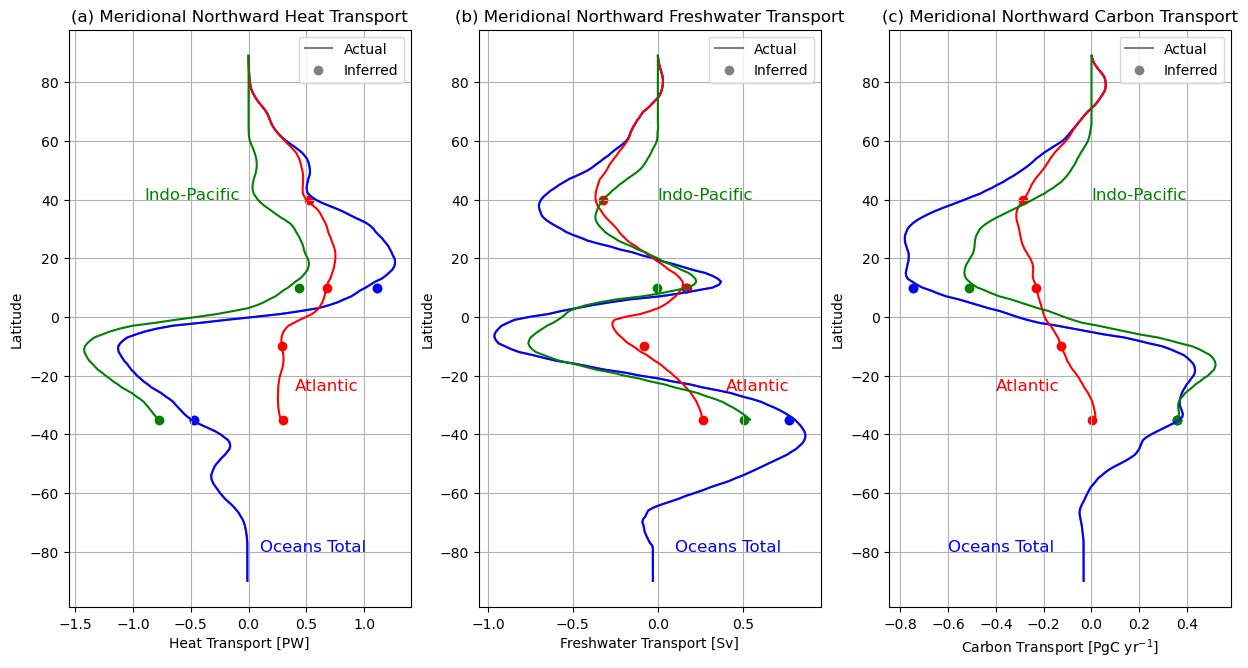

In [32]:
## Plot model heat, freshwater and carbon transports compared to OTM solution for case 2


heattransp_global = xr.open_mfdataset('heatbudget_ECCO.nc').heattransp_global
heattransp_ATL = xr.open_mfdataset('heatbudget_ECCO.nc').heattransp_ATL
heattransp_INDPAC = xr.open_mfdataset('heatbudget_ECCO.nc').heattransp_INDPAC

fwtransp_global = xr.open_mfdataset('fwbudget_ECCO.nc').fwtransp_global
fwtransp_ATL = xr.open_mfdataset('fwbudget_ECCO.nc').fwtransp_ATL
fwtransp_INDPAC = xr.open_mfdataset('fwbudget_ECCO.nc').fwtransp_INDPAC

Ctransp_global = xr.open_mfdataset('Cbudget_ECCO.nc').Ctransp_global
Ctransp_ATL = xr.open_mfdataset('Cbudget_ECCO.nc').Ctransp_ATL
Ctransp_INDPAC = xr.open_mfdataset('Cbudget_ECCO.nc').Ctransp_INDPAC

latgrid=np.arange(-90,90)

yeardiff = (month_init_late-month_init_early).values/12
yearsecs = 3600*24*365.25

heattransp2PW = 10**-15/(yeardiff*yearsecs)
Ctransp2PgCperyr = 12*10**-18/yeardiff
fwtransp2Sv = 10**-6/(rho*yeardiff*yearsecs)


fig, axes = plt.subplots(1,3,figsize=(15,7.5))


fs=12

# Heat

axes[0].plot(-heattransp_global*heattransp2PW,latgrid,'grey')
axes[0].scatter(heattransp_global_MTM/10**3,lats_global,c='grey')
axes[0].legend(['Actual','Inferred'])

axes[0].plot(-heattransp_global*heattransp2PW,latgrid,'b')
axes[0].scatter(heattransp_global_MTM/10**3,lats_global,c='b')

axes[0].plot(-heattransp_ATL*heattransp2PW,latgrid,'r')
axes[0].scatter(heattransp_ATL_MTM/10**3,lats_ATL,c='r')

axes[0].plot(-heattransp_INDPAC*heattransp2PW,latgrid,'g')
axes[0].scatter(heattransp_INDPAC_MTM/10**3,lats_INDPAC,c='g')

axes[0].annotate('Oceans Total', (0.1,-80), color='b', fontsize=fs)
axes[0].annotate('Indo-Pacific', (-0.9,40), color='g', fontsize=fs)
axes[0].annotate('Atlantic', (0.4,-25), color='r', fontsize=fs)

axes[0].set_xlabel('Heat Transport [PW]')
axes[0].set_ylabel('Latitude')
axes[0].grid()
axes[0].set_yticks(np.arange(-80,100,20))
axes[0].set_title('(a) Meridional Northward Heat Transport')


# Freshwater

axes[1].plot(-fwtransp_global*fwtransp2Sv,latgrid,'grey')
axes[1].scatter(fwtransp_global_MTM,lats_global,c='grey')
axes[1].legend(['Actual','Inferred'])

axes[1].plot(-fwtransp_global*fwtransp2Sv,latgrid,'b')
axes[1].scatter(fwtransp_global_MTM,lats_global,c='b')

axes[1].plot(-fwtransp_ATL*fwtransp2Sv,latgrid,'r')
axes[1].scatter(fwtransp_ATL_MTM,lats_ATL,c='r')

axes[1].plot(-fwtransp_INDPAC*fwtransp2Sv,latgrid,'g')
axes[1].scatter(fwtransp_INDPAC_MTM,lats_INDPAC,c='g')

axes[1].annotate('Oceans Total', (0.1,-80), color='b', fontsize=fs)
axes[1].annotate('Indo-Pacific', (0,40), color='g', fontsize=fs)
axes[1].annotate('Atlantic', (0.4,-25), color='r', fontsize=fs)

axes[1].set_xlabel('Freshwater Transport [Sv]')
axes[1].set_ylabel('Latitude')
axes[1].grid()
axes[1].set_yticks(np.arange(-80,100,20))
axes[1].set_title('(b) Meridional Northward Freshwater Transport')

# Carbon

axes[2].plot(-Ctransp_global*Ctransp2PgCperyr,latgrid,'grey')
axes[2].scatter(Ctransp_global_MTM,lats_global,c='grey')
axes[2].legend(['Actual','Inferred'])

axes[2].plot(-Ctransp_global*Ctransp2PgCperyr,latgrid,'b')
axes[2].scatter(Ctransp_global_MTM,lats_global,c='b')

axes[2].plot(-Ctransp_ATL*Ctransp2PgCperyr,latgrid,'r')
axes[2].scatter(Ctransp_ATL_MTM,lats_ATL,c='r')

axes[2].plot(-Ctransp_INDPAC*Ctransp2PgCperyr,latgrid,'g')
axes[2].scatter(Ctransp_INDPAC_MTM,lats_INDPAC,c='g')

axes[2].annotate('Oceans Total', (-0.6,-80), color='b', fontsize=fs)
axes[2].annotate('Indo-Pacific', (0,40), color='g', fontsize=fs)
axes[2].annotate('Atlantic', (-0.4,-25), color='r', fontsize=fs)

axes[2].set_xlabel('Carbon Transport [PgC yr$^{-1}$]')
axes[2].set_ylabel('Latitude')
axes[2].grid()
axes[2].set_yticks(np.arange(-80,100,20))
axes[2].set_title('(c) Meridional Northward Carbon Transport')

plt.savefig('true_meridional_transports.png', bbox_inches='tight', dpi=300, transparent=True)             


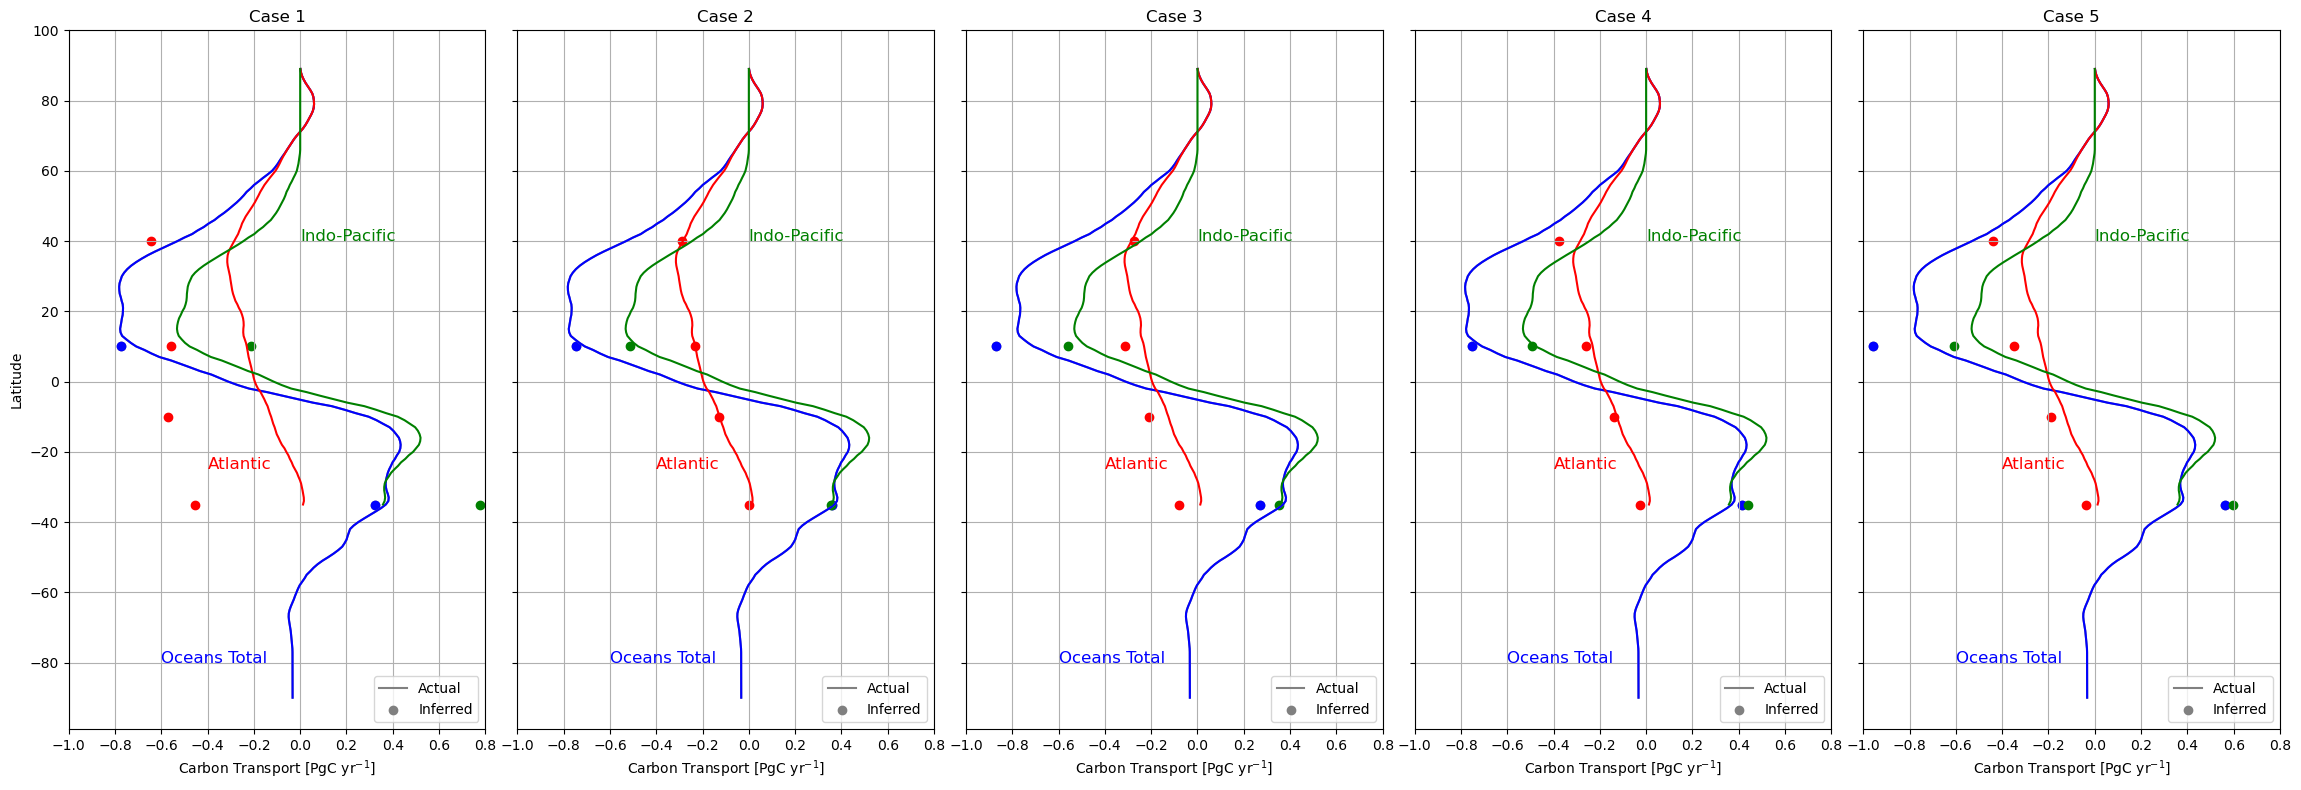

In [33]:
# Plot model carbon transports compared to OTM solution for cases 1-4

fig, axes = plt.subplots(1,5,figsize=(23,8))


fs=12

xlim = (-1,0.8)

# No prior

axes[0].plot(-Ctransp_global*Ctransp2PgCperyr,latgrid,'grey')
axes[0].scatter(Ctransp_global_MTM_noprior,lats_global,c='grey')
axes[0].legend(['Actual','Inferred'],loc='lower right')

axes[0].plot(-Ctransp_global*Ctransp2PgCperyr,latgrid,'b')
axes[0].scatter(Ctransp_global_MTM_noprior,lats_global,c='b')

axes[0].plot(-Ctransp_ATL*Ctransp2PgCperyr,latgrid,'r')
axes[0].scatter(Ctransp_ATL_MTM_noprior,lats_ATL,c='r')

axes[0].plot(-Ctransp_INDPAC*Ctransp2PgCperyr,latgrid,'g')
axes[0].scatter(Ctransp_INDPAC_MTM_noprior,lats_INDPAC,c='g')

axes[0].annotate('Oceans Total', (-0.6,-80), color='b', fontsize=fs)
axes[0].annotate('Indo-Pacific', (0,40), color='g', fontsize=fs)
axes[0].annotate('Atlantic', (-0.4,-25), color='r', fontsize=fs)

axes[0].set_xlabel('Carbon Transport [PgC yr$^{-1}$]')
axes[0].set_ylabel('Latitude')
axes[0].grid()
axes[0].set_yticks(np.arange(-80,110,20))
axes[0].set_title('Case 1')
axes[0].set_xlim(xlim)


# True flux prior
axes[1].plot(-Ctransp_global*Ctransp2PgCperyr,latgrid,'grey')
axes[1].scatter(Ctransp_global_MTM,lats_global,c='grey')
axes[1].legend(['Actual','Inferred'],loc='lower right')

axes[1].plot(-Ctransp_global*Ctransp2PgCperyr,latgrid,'b')
axes[1].scatter(Ctransp_global_MTM,lats_global,c='b')

axes[1].plot(-Ctransp_ATL*Ctransp2PgCperyr,latgrid,'r')
axes[1].scatter(Ctransp_ATL_MTM,lats_ATL,c='r')

axes[1].plot(-Ctransp_INDPAC*Ctransp2PgCperyr,latgrid,'g')
axes[1].scatter(Ctransp_INDPAC_MTM,lats_INDPAC,c='g')

axes[1].annotate('Oceans Total', (-0.6,-80), color='b', fontsize=fs)
axes[1].annotate('Indo-Pacific', (0,40), color='g', fontsize=fs)
axes[1].annotate('Atlantic', (-0.4,-25), color='r', fontsize=fs)

axes[1].set_xlabel('Carbon Transport [PgC yr$^{-1}$]')
#axes[1].set_ylabel('Latitude')
axes[1].grid()
axes[1].set_yticks(np.arange(-80,110,20))
axes[1].set_title('Case 2')
axes[1].set_xlim(xlim)
axes[1].set_yticklabels([])

# Lower bound

axes[2].plot(-Ctransp_global*Ctransp2PgCperyr,latgrid,'grey')
axes[2].scatter(Ctransp_global_MTM_lb,lats_global,c='grey')
axes[2].legend(['Actual','Inferred'],loc='lower right')

axes[2].plot(-Ctransp_global*Ctransp2PgCperyr,latgrid,'b')
axes[2].scatter(Ctransp_global_MTM_lb,lats_global,c='b')

axes[2].plot(-Ctransp_ATL*Ctransp2PgCperyr,latgrid,'r')
axes[2].scatter(Ctransp_ATL_MTM_lb,lats_ATL,c='r')

axes[2].plot(-Ctransp_INDPAC*Ctransp2PgCperyr,latgrid,'g')
axes[2].scatter(Ctransp_INDPAC_MTM_lb,lats_INDPAC,c='g')

axes[2].annotate('Oceans Total', (-0.6,-80), color='b', fontsize=fs)
axes[2].annotate('Indo-Pacific', (0,40), color='g', fontsize=fs)
axes[2].annotate('Atlantic', (-0.4,-25), color='r', fontsize=fs)

axes[2].set_xlabel('Carbon Transport [PgC yr$^{-1}$]')
#axes[2].set_ylabel('Latitude')
axes[2].grid()
axes[2].set_yticks(np.arange(-80,110,20))
axes[2].set_title('Case 3')
axes[2].set_xlim(xlim)
axes[2].set_yticklabels([])

# Upper bound

axes[3].plot(-Ctransp_global*Ctransp2PgCperyr,latgrid,'grey')
axes[3].scatter(Ctransp_global_MTM_ub,lats_global,c='grey')
axes[3].legend(['Actual','Inferred'],loc='lower right')

axes[3].plot(-Ctransp_global*Ctransp2PgCperyr,latgrid,'b')
axes[3].scatter(Ctransp_global_MTM_ub,lats_global,c='b')

axes[3].plot(-Ctransp_ATL*Ctransp2PgCperyr,latgrid,'r')
axes[3].scatter(Ctransp_ATL_MTM_ub,lats_ATL,c='r')

axes[3].plot(-Ctransp_INDPAC*Ctransp2PgCperyr,latgrid,'g')
axes[3].scatter(Ctransp_INDPAC_MTM_ub,lats_INDPAC,c='g')

axes[3].annotate('Oceans Total', (-0.6,-80), color='b', fontsize=fs)
axes[3].annotate('Indo-Pacific', (0,40), color='g', fontsize=fs)
axes[3].annotate('Atlantic', (-0.4,-25), color='r', fontsize=fs)

axes[3].set_xlabel('Carbon Transport [PgC yr$^{-1}$]')
#axes[3].set_ylabel('Latitude')
axes[3].grid()
axes[3].set_yticks(np.arange(-80,110,20))
axes[3].set_title('Case 4')
axes[3].set_xlim(xlim)
axes[3].set_yticklabels([])

# Enhanced errors

axes[4].plot(-Ctransp_global*Ctransp2PgCperyr,latgrid,'grey')
axes[4].scatter(Ctransp_global_MTM_err,lats_global,c='grey')
axes[4].legend(['Actual','Inferred'],loc='lower right')

axes[4].plot(-Ctransp_global*Ctransp2PgCperyr,latgrid,'b')
axes[4].scatter(Ctransp_global_MTM_err,lats_global,c='b')

axes[4].plot(-Ctransp_ATL*Ctransp2PgCperyr,latgrid,'r')
axes[4].scatter(Ctransp_ATL_MTM_err,lats_ATL,c='r')

axes[4].plot(-Ctransp_INDPAC*Ctransp2PgCperyr,latgrid,'g')
axes[4].scatter(Ctransp_INDPAC_MTM_err,lats_INDPAC,c='g')

axes[4].annotate('Oceans Total', (-0.6,-80), color='b', fontsize=fs)
axes[4].annotate('Indo-Pacific', (0,40), color='g', fontsize=fs)
axes[4].annotate('Atlantic', (-0.4,-25), color='r', fontsize=fs)

axes[4].set_xlabel('Carbon Transport [PgC yr$^{-1}$]')
#axes[4].set_ylabel('Latitude')
axes[4].grid()
axes[4].set_yticks(np.arange(-80,110,20))
axes[4].set_title('Case 5')
axes[4].set_xlim(xlim)
axes[4].set_yticklabels([])

plt.tight_layout()

plt.savefig('allpriors_meridional_carbon_transports_alt.png', bbox_inches='tight', dpi=300, transparent=True)             


In [34]:
# Calculate the range of MTM values

Ctransp_ATL_MTM_all = np.concatenate((Ctransp_ATL_MTM,Ctransp_ATL_MTM_ub,Ctransp_ATL_MTM_lb,Ctransp_ATL_MTM_err),axis=1)
range_ATL = np.ptp(Ctransp_ATL_MTM_all,axis=1)

Ctransp_INDPAC_MTM_all = np.concatenate((Ctransp_INDPAC_MTM,Ctransp_INDPAC_MTM_ub,Ctransp_INDPAC_MTM_lb,Ctransp_INDPAC_MTM_err),axis=1)
range_INDPAC = np.ptp(Ctransp_INDPAC_MTM_all,axis=1)

Ctransp_global_MTM_all = np.concatenate((Ctransp_global_MTM,Ctransp_global_MTM_ub,Ctransp_global_MTM_lb,Ctransp_global_MTM_err),axis=1)
range_global = np.ptp(Ctransp_global_MTM_all,axis=1)

print('ATL range:')
print(range_ATL)
print('INDPAC range:')
print(range_INDPAC)
print('Global range:')
print(range_global)


ATL range:
[0.16511731 0.11558973 0.08362224 0.08044987]
INDPAC range:
[0.11386644 0.24667477]
Global range:
[0.21108671 0.29019176]


In [35]:
lats_global

[10, -35]